# EDSA - Climate Change Belief Analysis
#### Classification_TS3_DSFT21
------------------------------

<img src="images/Adaptacion_746x419.jpg"
     style="float: center; padding-bottom=0.5em"
     width=600px/>   
-------------------------------

## Table of Contents

1. <a href ="#1.-Challenge-description">Challenge description</a>
2. <a href ="#2.-Introduction">Introduction</a>
3. <a href ="#3.-Importing-Libraries">Importing Libraries</a>
4. <a href ="#4.-Importing-Data">Importing Data</a>
5. <a href ="#5.-Data-Preprocessing">Data Preprocessing</a>
6. <a href ="#6.-Exploratory-Data-Analysis">Exploratory Data Analysis</a>


# 1. Challenge description

Many companies are built around lessening one's environmental impact or carbon foot print. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climante change and whether or not they belive it is a real threat. This would add to their market research efforts in gaugin how their product/service may be received.

With this context, EDSA is challending us during the Classification Sprint with the task of creating a Machine Learning mode that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

Providing an accurate and robust solution to the task gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies.


# 2. Introduction

To achieve this, we shall perform preprocessing of the data, statistical and exploratory data analysis, construct multiple machine learning models, train our models with regards to the sentiment expressed by the user and of course testing our model on unseen data to verify the validity of our model.

# 3. Importing Libraries

In this notebook we shall be importing various python libraries to assist with constructing our classification model.

In [150]:
import nltk

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re
from string import punctuation
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter


# set plot style
sns.set(style = 'whitegrid')

In [6]:
#Downloading NLTK Corpora
nltk.download(['punkt','stopwords'])

#Downloading wordnet for lemmatisation
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nknhl\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nknhl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 4. Importing Data

In [26]:
#Training set
train_df = pd.read_csv('data/train.csv')
#Test set
test_df = pd.read_csv('data/test.csv')

## Data Overview

Our training set consist of 3 columns:
* The sentiment : Indicates the sentiment of the tweet message
* message : The body of the tweet
* tweetid : Twitter unique id

In [3]:
train_df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


We look at the top rows of our data to the see the features as well as the types of data we are working with.

In [4]:
test_df.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


Let us get the dimensions of our data to figure out how many observations we have.

In [5]:
np.shape(train_df)

(15819, 3)

We have 15 819 Observations in our data.

Let us get the types of sentiments that are there and their descriptions.

In [6]:
list(train_df['sentiment'].unique())

[1, 2, 0, -1]

There are three class namely :
* 1 Pro: the tweet supports the belief of man-made climate
* 2 News: the tweet links to factual news about climate change
* 0 Neutral: the tweet neither supports nor refutes the belief of man-made climate change
* -1 Anti: the tweet does not believe in man-made climate change

Now Let's obtain the counts of each class of sentiments and plot them on a bar graph

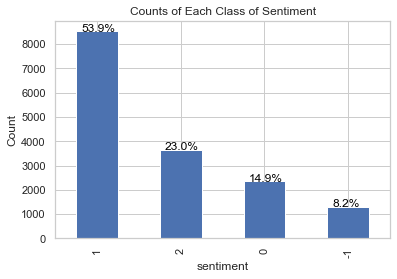

In [7]:
ax = train_df['sentiment'].value_counts().plot(kind = 'bar', 
                                          title = 'Counts of Each Class of Sentiment',
                                          xlabel = 'sentiment', 
                                          ylabel = 'Count')
n_obs = [i.get_height() for i in ax.patches]
total = sum(n_obs)

for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+0.06, i.get_height()+0.5, \
            str(round((i.get_height()/total)*100, 1))+'%', fontsize=12,
                color='black')

From the figure above, we observed that we have unbalanced classes. 
* The majority of tweets (53.9%) support the belief of man-made climate change. 
* 23% consist of factual news regarding climate change. 
* 14.9% are neutral about man-made climate change
* 8.2% don't believe in man-made climate change

## 5. Data Preprocessing

### Noise Removal


We started removing all the urls.


In [27]:
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'

train_df['clean_message'] = train_df['message'].replace(to_replace = pattern_url, value = '', regex = True)

Followed by the twitter mentions:


In [28]:
mentions = r'@[\w]*'

train_df['clean_message'] = train_df['clean_message'].replace(to_replace = mentions, value = '', regex = True)

We removed the hashtags:


In [29]:
hashtags = r'#[\w]*'

train_df['clean_message'] = train_df['clean_message'].replace(to_replace = hashtags, value = '', regex = True)

What about retweets? should we remove them?

We removed the punctuation

In [38]:
train_df['clean_message'] = train_df['clean_message'].apply(lambda x: ''.join(i for i in x if i not in punctuation))

we changed all the words to lowercase:

In [39]:
train_df['clean_message'] = train_df['clean_message'].str.lower()

In [40]:
train_df.head()

,sentiment,message,tweetid,clean_message,tokens
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doesnt think carbon dio...,"[polyscimajor, epa, chief, doesnt, think, carb..."
1,1,It's not like we lack evidence of anthropogeni...,126103,its not like we lack evidence of anthropogenic...,"[its, not, like, we, lack, evidence, of, anthr..."
2,2,RT @RawStory: Researchers say we have three ye...,698562,rt researchers say we have three years to act...,"[rt, researchers, say, we, have, three, years,..."
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,wired 2016 was a pivotal year in the war on ...,"[wired, 2016, was, a, pivotal, year, in, the, ..."
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,rt its 2016 and a racist sexist climate chang...,"[rt, its, 2016, and, a, racist, sexist, climat..."


### Tokenisation

In [33]:
#We first initialise our tokenizer
tokeniser = TreebankWordTokenizer()
train_df['tokens'] =train_df['clean_message'].apply(tokeniser.tokenize)

In [34]:
train_df.head()

,sentiment,message,tweetid,clean_message,tokens
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doesnt think carbon dio...,"[polyscimajor, epa, chief, doesnt, think, carb..."
1,1,It's not like we lack evidence of anthropogeni...,126103,its not like we lack evidence of anthropogenic...,"[its, not, like, we, lack, evidence, of, anthr..."
2,2,RT @RawStory: Researchers say we have three ye...,698562,rt researchers say we have three years to act...,"[rt, researchers, say, we, have, three, years,..."
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,wired 2016 was a pivotal year in the war on ...,"[wired, 2016, was, a, pivotal, year, in, the, ..."
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,rt its 2016 and a racist sexist climate chang...,"[rt, its, 2016, and, a, racist, sexist, climat..."


### Data Normalisation

We will be using Lemmatization although it's a bit slower than stemming

In [44]:
lemmatizer = WordNetLemmatizer()

train_df['tokens'] = train_df['tokens'].apply(lambda y: [lemmatizer.lemmatize(i) for i in y])

In [45]:
train_df.head()

,sentiment,message,tweetid,clean_message,tokens
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doesnt think carbon dio...,"[polyscimajor, epa, chief, doesnt, think, carb..."
1,1,It's not like we lack evidence of anthropogeni...,126103,its not like we lack evidence of anthropogenic...,"[it, not, like, we, lack, evidence, of, anthro..."
2,2,RT @RawStory: Researchers say we have three ye...,698562,rt researchers say we have three years to act...,"[rt, researcher, say, we, have, three, year, t..."
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,wired 2016 was a pivotal year in the war on ...,"[wired, 2016, wa, a, pivotal, year, in, the, w..."
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,rt its 2016 and a racist sexist climate chang...,"[rt, it, 2016, and, a, racist, sexist, climate..."


### Stop Words

In [47]:
train_df['tokens'] = train_df['tokens'].apply(lambda z: [i for i in z if i not in stopwords.words('english')])

In [134]:
# clean_message without stop words
train_df['clean_message'] = train_df['tokens'].apply(lambda a: ' '.join([i for i in a]))
train_df.head()

,sentiment,message,tweetid,clean_message,tokens
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doesnt think carbon dio...,"[polyscimajor, epa, chief, doesnt, think, carb..."
1,1,It's not like we lack evidence of anthropogeni...,126103,like lack evidence anthropogenic global warming,"[like, lack, evidence, anthropogenic, global, ..."
2,2,RT @RawStory: Researchers say we have three ye...,698562,rt researcher say three year act climate chang...,"[rt, researcher, say, three, year, act, climat..."
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,wired 2016 wa pivotal year war climate change,"[wired, 2016, wa, pivotal, year, war, climate,..."
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,rt 2016 racist sexist climate change denying b...,"[rt, 2016, racist, sexist, climate, change, de..."


## 6. Exploratory Data Analysis

Now let's us study the distribution of the length of the words
* First we obtained a list containing all the words
* We obtained the lenth of each word and counted the number of times the word appears in our list
* we grouped frequencies by lenght and summed them up.

In [120]:
word_list =  train_df['tokens'].values
all_words_ls=[word_list[i][j] for i in range(len(word_list)) for j in range(len(word_list[i]))]
word_length_each =pd.DataFrame([[len(i),all_words_ls.count(i)] for i in set(all_words_ls)], columns = ['word_length','frequency'])

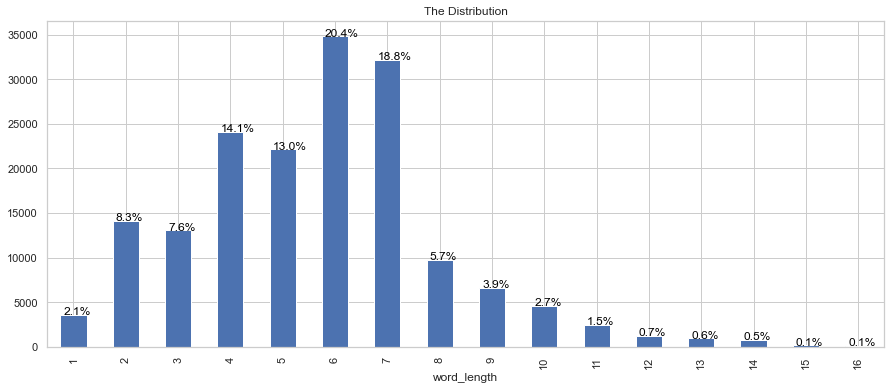

In [126]:
word_length_freq = word_length_each.groupby('word_length')['frequency'].sum().head(16).plot(kind ='bar', 
                                                                                           title = "The Distribution", 
                                                                                           figsize = (15,6))
n_obs = [i.get_height() for i in word_len_bar.patches]
total = sum(n_obs)

for i in word_length_freq.patches:
    # get_x pulls left or right; get_height pushes up or down
    word_length_freq.text(i.get_x()+0.06, i.get_height()+0.5, \
            str(round((i.get_height()/total)*100, 1))+'%', fontsize=12,
                color='black')

The dataset contained word length that going up to 100. For visualisation purposes, we limited our range to [1-16]. The figure above indicates that the word length is positively skewed, this indicates the presence of outliers to the right of peak of the graph. Additionally, the most common word length is 6. Roughly 10% of our data consist of words that have lengths 1 and 2.


We created a wordcloud for all the words in our clean dataset to see the most common words in tweets.

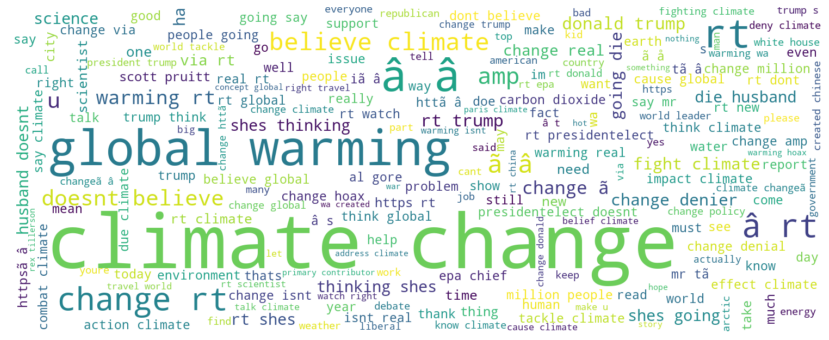

In [218]:
all_words = ' '.join(all_words_ls)

wordcloud = WordCloud(width=1500, height=600,  background_color='white').generate(all_words)

plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

From The above we can see that our data still has a bit of noise. We might need to remove words of length less than 3.



We then obtained the most occurring words tweets that do not believe in man-made climate change

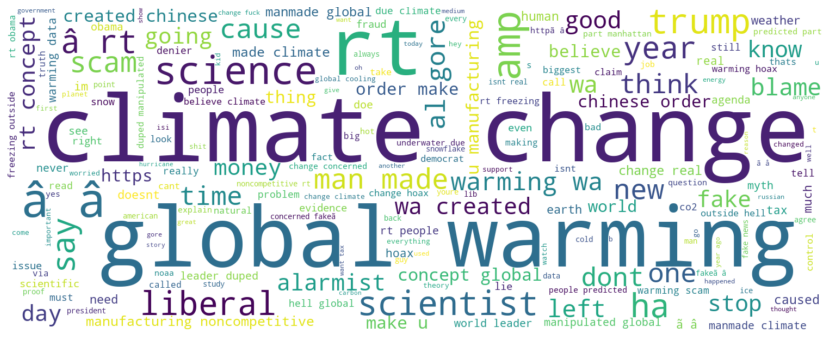

In [214]:
neg_words = ' '.join([text for text in train_df['clean_message'][train_df['sentiment'] == -1]])

wordcloud = WordCloud(width=1500, height=600,  background_color='white').generate(neg_words)

plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

We obtained the most frequently used words to tweets that displayed belief in man-made climate change

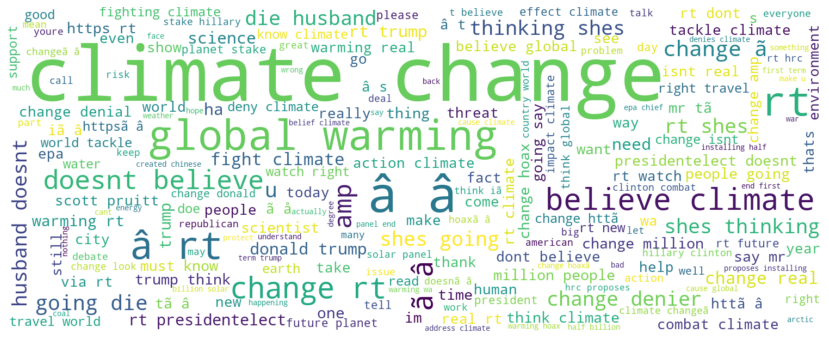

In [213]:
pro_words = ' '.join([text for text in train_df['clean_message'][train_df['sentiment'] == 1]])

wordcloud = WordCloud(width=1500, height=600,  background_color='white').generate(pro_words)

plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Neutral

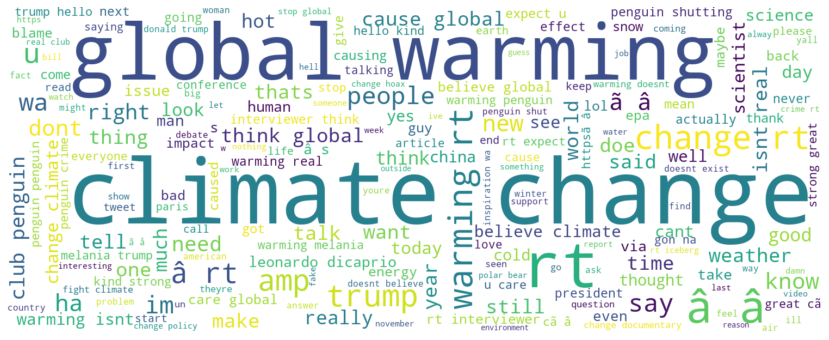

In [212]:
neg_words = ' '.join([text for text in train_df['clean_message'][train_df['sentiment'] == 0]])

wordcloud = WordCloud(width=1500, height=600,  background_color='white').generate(neg_words)

plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Factual News about man-made cimate change

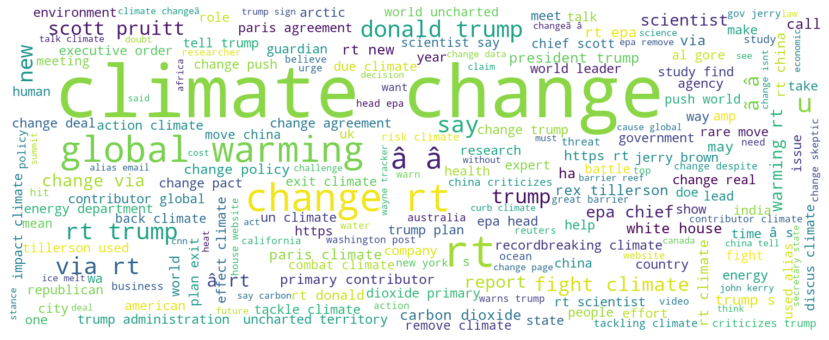

In [210]:
neg_words = ' '.join([text for text in train_df['clean_message'][train_df['sentiment'] == 2]])

wordcloud = WordCloud(width=1500, height=600,  background_color='white').generate(neg_words)

plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Our analysis above indicated that we might need to remove words with length 1 and 2. Words such as rt  and $\tilde{a}$. So we limited our analysis to these lengths to see the most frequenty occuring words.


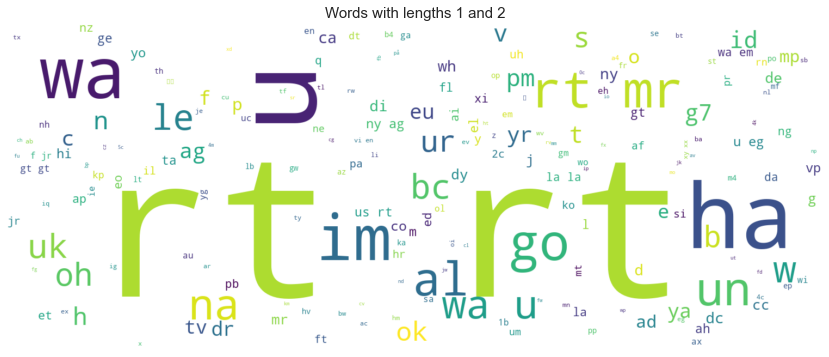

In [211]:
len_12 = ' '.join([i for i in all_words_ls if len(i)<3])
neg_words = ' '.join([text for text in train_df['clean_message'][train_df['sentiment'] == 2]])

wordcloud = WordCloud(width=1500, height=600,  background_color='white').generate(len_12)
plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Words with lengths 1 and 2', fontsize=15)
plt.axis('off')
plt.show()

The words above were regarded as noise. We decided to remove all the words with a length less than 3.

In [148]:
less_than_3 = [i for i in all_words_ls if len(i)<3]

train_df['tokens'] = train_df['tokens'].apply(lambda x : [i for i in x if i not in less_than_3])

In [149]:
train_df.head()

,sentiment,message,tweetid,clean_message,tokens
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doesnt think carbon dio...,"[polyscimajor, epa, chief, doesnt, think, carb..."
1,1,It's not like we lack evidence of anthropogeni...,126103,like lack evidence anthropogenic global warming,"[like, lack, evidence, anthropogenic, global, ..."
2,2,RT @RawStory: Researchers say we have three ye...,698562,rt researcher say three year act climate chang...,"[researcher, say, three, year, act, climate, c..."
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,wired 2016 wa pivotal year war climate change,"[wired, 2016, pivotal, year, war, climate, cha..."
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,rt 2016 racist sexist climate change denying b...,"[2016, racist, sexist, climate, change, denyin..."


## 7. Feature Extraction
In this section we tried different techniques for feature extraction, we tried each of the following techniques to see the one that gives us the best performance:

7.1. <a href ="#7.1.-Bag-of-Words">Bag of Words</a>


7.2. <a href ="#7.2.-Ngrams">Ngrams</a>


### 7.1. Bag of Words

This is the most basic feature extraction techniques, It ignores the  it takes in a containing all the clean words in our corpus and returns a dictionary containing the words as keys and their frequencies as values.

<img src="images/bag_of_word1.png"
     style="float: center; padding-bottom=0.5em"
     width=600px/>
     
For each and every row, the text is going to be vectorized by in this form:
<img src="images/bag_of_word2.png"
     style="float: center; padding-bottom=0.5em"
     width=600px/>



In [192]:
all_words_clean =[train_df['tokens'].values[i][j] for i in range(len(train_df['tokens'].values)) for j in range(len(train_df['tokens'].values[i]))]
bow = Counter(all_words_clean)from_records
clean_bow_df = pd.DataFrame.(list(dict(bow.most_common(10)).items()), columns=['word','count'])

Below is a vertical barchat showing the top 20 common words.

<AxesSubplot:title={'center':'Top 20 Common Words'}, ylabel='Word'>

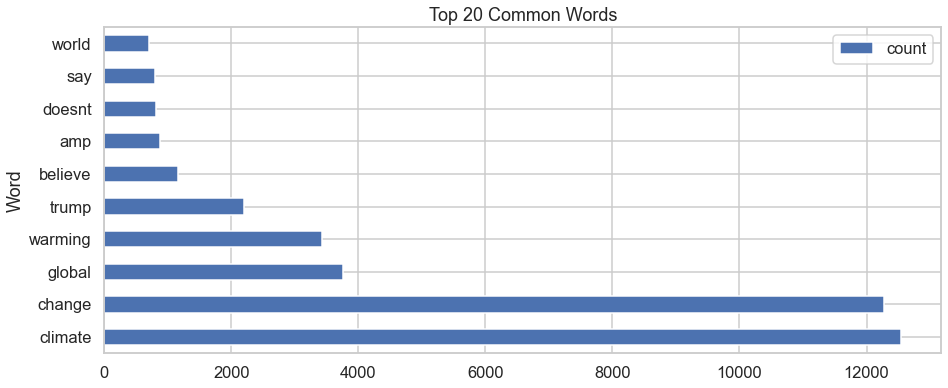

In [194]:
clean_bow_df.plot(x='word', y='count', kind='barh', title ='Top 20 Common Words', 
                  xlabel = 'Word', ylabel = 'Frequency', figsize = (15,6))

In [177]:
clean_bow_df['count'].min()


515

### 7.2. Ngrams